In [2]:
#Data
import pandas as pd
#System
from os import walk
#Music Analysis
import music21 as m21

#Maths
from collections import Counter
import numpy as np
import itertools as it
import random as rd

#Encodage
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import re
from tqdm import tqdm

#Graphics/Visualization
from matplotlib import pyplot as plt

m21.environment.set('musescoreDirectPNGPath', '/Applications/MuseScore 3.app/contents')

## Data Preprocessing

In [3]:
midiPath = "MarkovDataBase"
fileName = "Bwv1041 Violin Concerto n1 1mov.mid"
filePath = midiPath+"/"+fileName

def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

def transposeMidi(midi, key="C") :
    k = midi.analyze('key')
    i = m21.interval.Interval(k.tonic, m21.pitch.Pitch(key))
    midiNew = midi.transpose(i)
    return midiNew

def midi2solo(midiPath, partName = "Solo Violin", transpose = "C") :
    midiTemp = m21.converter.parse(midiPath)
    
    notes = []
    
    for partTemp in midiTemp.parts:
        if partTemp.partName == "Solo Violin" :
            #transposition
            if transpose :
                part = transposeMidi(partTemp, transpose)
            else :
                part = partTemp
                
            for element in part.recurse() :
                if isinstance(element, m21.note.Note) :
                    notes.append(element.name+str(element.octave)+"_"+str(element.duration)[27:-1])
                elif isinstance(element, m21.note.Rest) :
                    notes.append(element.name+"_"+str(element.duration)[27:-1])
    return notes

def solo2midi(solo) :
    s = m21.stream.Stream()
    for element in solo :
        noteTemp, durationTemp = element.split("_")
        d = m21.duration.Duration(convert_to_float(durationTemp))
        if noteTemp == "rest" :
            note = m21.note.Rest(d)
        else :
            note = m21.note.Note(noteTemp, duration = d)
        s.append(note)
    return s

def musicDataBase(myDirectory, transpose = False) :
    print("Creating the musical data base...\n")
    solos = []
    for (directory, subdirectory, files) in walk(myDirectory):
        for file in files :
            solo = midi2solo(directory+"/"+file, transpose = transpose)
            for element in solo :  
                solos.append(element)
    print("Success !")
    return solos

In [4]:
solos = musicDataBase("MarkovDataBase", "C")

Creating the musical data base...

Success !


In [5]:
class Solo :
    def __init__(self, notes) :
        self.notes_sequence = notes
        self.length = len(notes)
        self.dimension = len(set(notes))
        self.notes_frequency = dict(Counter(solos))
    
    def notesRepartition(self) :
        #consider only the frequencies
        no=[count for _,count in self.notes_frequency.items()]
        #set the figure size
        plt.figure(figsize=(5,5))
        #plot
        plt.hist(no)
        
    def sweetSpot(self, show=True) :
        removed = []
        vocab = []
        sweetSpot = 0
        sweetSpotInd=0
        for i in range(0, 200) :
            frequent_notes = [note_ for note_, count in self.notes_frequency.items() if count>=i]
            newSolo = simplifyPiece(self.notes_sequence, frequent_notes)
            p = (self.length-len(newSolo))/self.length #Pourcent of loss notes
            v = len(set(newSolo))
            ssp = p*v
            if ssp>sweetSpot :
                sweetSpot = ssp
                sweetSpotInd = i
            removed.append(p)
            vocab.append(v)
        if show :
            #set the figure size
            plt.figure(figsize=(5,5))
            plt.plot(vocab, removed)
            plt.ylabel('removed notes')
            plt.xlabel('different notes')
            plt.show()
            print("The sweet spot seems to be around : ", sweetSpotInd)
        return sweetSpotInd
    
    def frequentNotes(self, indice=False) :
        if not(indice):
            indice = self.sweetSpot(show=False)
        frequent_notes = [note_ for note_, count in self.notes_frequency.items() if count>=indice]
        return frequent_notes
        
    def simplifyPiece(self, frequent_notes = False):
        if not(frequent_notes) :
            frequent_notes = self.frequentNotes()
        new_solo=[]
        for note in self.notes_sequence:
            if note in frequent_notes:          
                new_solo.append(note)
        p = (self.length-len(newSolo))/self.length
        v = len(set(newSolo))
        print(round(p,3), "% notes have been removed, there is now ", v, "different notes.")
        return Solo(new_solo)
    

In [1]:
solo = Solo(solos)
print(solo.notes_sequence)
solo.notesRepartition()
solo.sweetSpot()

NameError: name 'Solo' is not defined

In [257]:
new_solo = solo.simplifyPiece()

0.294 % notes have been removed, there is now  25 different notes.


## Markov Model

In [258]:
def transitionMatrix(sequence, n_gram=1) :
    """Compute the transition matrix of a sequence regarding on the following state after a sequence of length ngram
    
    Parameters
    ----------
    sequence : array-like of states
        Sequence of state observed
    n : int 
        Length of the sequence that precede the predicted next state
        
    Returns
    -------
    transition_matrix : 
    """
    transitionDict = {}
    for i in tqdm(range(len(sequence)-n_gram)):
        currentNgram = []
        for j in range(n_gram) :
            currentNgram.append(sequence[i+j])
        currentNgram = tuple(currentNgram)
        if currentNgram in transitionDict :
            if sequence[i+n_gram] in transitionDict[currentNgram] :
                transitionDict[currentNgram][sequence[i+n_gram]]+=1
            else :
                transitionDict[currentNgram][sequence[i+n_gram]]=1
        else :
            transitionDict[currentNgram] = {sequence[i+n_gram]:1}
                
    transitionDf = pd.DataFrame(transitionDict).T
    
    return(transitionDf.div(transitionDf.sum(axis=1), axis=0).fillna(0))

def sequencify(transition_matrix, startingSeq, seqLength=1000, n=1) :
    if len(startingSeq) < n :
        print("The starting sequence should be longer than the length of the ngram...")
    sequence = startingSeq
    state =""
    for i in range(seqLength):
        currentNgram = tuple(sequence[-n:len(sequence)])
        prob=transition_matrix.loc[currentNgram]
        val=list(transition_matrix.columns)
        state = np.random.choice(val, p = prob)
        sequence.append(state)
    return(sequence)
        


class MMarkov :
    def __init__(self, order = 1) :
        self.order = order

    def fit(self, X) :
        self.nState = len(set(X))
        self.transition_matrix = transitionMatrix(X, self.order)
        return self
    
    def sequencify(self, startingSeq, seqLength) :
        return sequencify(self.transition_matrix, startingSeq, seqLength, self.order)
    
    def interest(self, log=True) :
        overfitted_val = 0 #Une valeur est overfit si elle n'a qu'un etat suivant possible
        supZtot=0
        for ind in self.transition_matrix :
            supZ = 0
            for val in self.transition_matrix[ind] :
                supZ+=val>0
            if log :
                supZtot+=np.log(supZ)
            else :
                supZtot+=supZ
        self.interest = supZtot/len(self.transition_matrix.index)
        return self.interest
    
    def coherence(self, testSeq) :
        coherence = 0
        for i in range(len(testSeq)-self.order):
            currentNgram = []
            for j in range(self.order) :
                currentNgram.append(testSeq[i+j])
            currentNgram = tuple(currentNgram)
            if currentNgram in self.transition_matrix.index :
                #print(currentNgram, testSeq[i+self.order], self.transition_matrix.T[currentNgram])
                if testSeq[i+self.order] in self.transition_matrix.T[currentNgram] :
                    coherence+=self.transition_matrix.T[currentNgram][testSeq[i+self.order]]
        return coherence/(len(testSeq)-self.order)

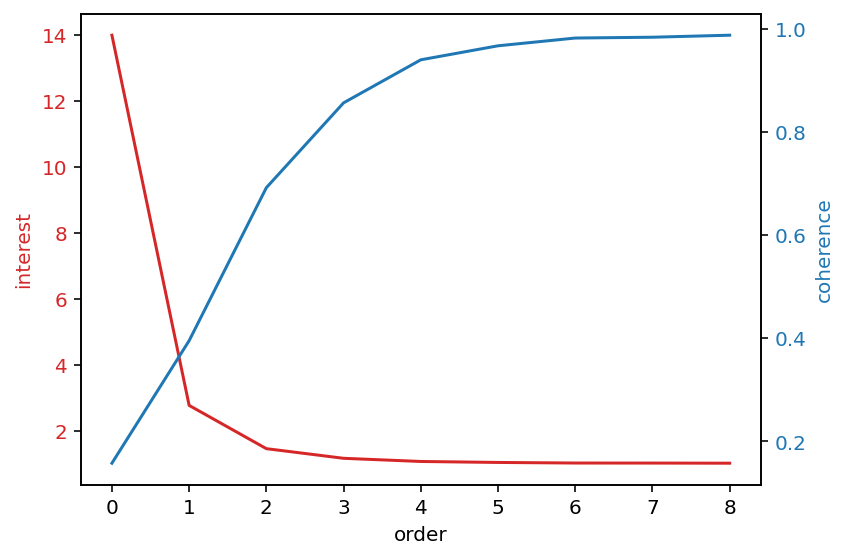

Most interesting order :  1


In [263]:
co = []
inte = []
sweetSpot = 0
sweetSpotInd = 0
for i in range(1,10) :
    model = MMarkov(i)
    model.fit(new_solo.notes_sequence)
    inter = model.interest(log=False)
    inte.append(inter)
    cohe = model.coherence(new_solo.notes_sequence)
    co.append(cohe)
    ssp = inter*cohe
    if ssp>sweetSpot :
        sweetSpot = ssp
        sweetSpotInd = i

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('order')
ax1.set_ylabel('interest', color=color)
ax1.plot(inte, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('coherence', color=color)  # we already handled the x-label with ax1
ax2.plot(co, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print("Most interesting order : ", sweetSpotInd)



In [75]:
solo.notes_sequence

['rest_16.0',
 'C5_1.0',
 'B-4_0.0',
 'rest_0.25',
 'A4_0.0',
 'rest_1/12',
 'G4_0.0',
 'rest_1/6',
 'F4_0.25',
 'E4_0.25',
 'F4_0.25',
 'C5_0.75',
 'B-4_0.0',
 'rest_0.25',
 'A4_0.0',
 'rest_1/12',
 'G4_0.0',
 'rest_1/6',
 'F4_0.25',
 'E4_0.25',
 'F4_0.25',
 'E-5_0.25',
 'D5_0.25',
 'F4_0.25',
 'D5_0.25',
 'C5_0.25',
 'E4_0.25',
 'C5_0.25',
 'B-4_0.25',
 'F4_0.25',
 'B-4_0.25',
 'A4_0.25',
 'G4_0.25',
 'B4_0.25',
 'C5_0.25',
 'C4_0.5',
 'rest_9.0',
 'A4_1.25',
 'F4_0.25',
 'E4_0.25',
 'F4_0.25',
 'A4_0.25',
 'D5_0.25',
 'D5_0.5',
 'G4_2/3',
 'rest_1/12',
 'E4_0.25',
 'D4_0.25',
 'E4_0.25',
 'G4_0.25',
 'C5_0.25',
 'C5_0.25',
 'B4_0.25',
 'A4_0.25',
 'B4_0.25',
 'D5_0.25',
 'F5_0.25',
 'F5_0.25',
 'E5_0.25',
 'D5_0.25',
 'C5_0.25',
 'B4_0.25',
 'A4_0.25',
 'G4_1.25',
 'B4_0.25',
 'D5_0.25',
 'F5_0.25',
 'E5_0.25',
 'D5_0.25',
 'E5_0.25',
 'G5_0.25',
 'F5_0.25',
 'E5_0.25',
 'D5_0.25',
 'C5_0.25',
 'B-4_0.25',
 'A4_0.25',
 'B-4_0.25',
 'B-4_2/3',
 'rest_1/12',
 'C4_0.25',
 'D4_0.25',
 '

In [76]:
s = model.sequencify(['C4_0.25','D4_0.25'], 300)

In [77]:
stream = solo2midi(s)

In [78]:
stream.show()